In [97]:
# necessary packages
import pandas as pd
import multiprocessing as mp
import time
import pickle
import networkx
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Getting the Dataset

Either download the csv file from the this Google Drive link, or make the following SQL query in Google BigQuery and export the table. 

https://drive.google.com/file/d/1K_cSITzrYyyFd-VVXiVYY4v86epd76s4/view?usp=sharing


```
SELECT
        `hash` as tx_hash,
        size as tx_size,
        virtual_size,
        version,
        block_hash,
        block_timestamp,
        input_count,
        input_value,
        output_count,
        output_value,
        is_coinbase,
        fee,
        inputs.spent_transaction_hash as `inputs_spent_transaction_hash`,
        inputs.required_signatures as `inputs_required_signatures`,
        inputs.type as `inputs_type`,
        inputs.addresses[OFFSET(0)] as `inputs_addresses`,
        inputs.value as `inputs_value`,
        outputs.required_signatures as `outputs_required_signatures`,
        outputs.type as `outputs_type`,
        outputs.addresses[OFFSET(0)] as `outputs_addresses`,
        outputs.value as `outputs_value`
FROM `bigquery-public-data.crypto_litecoin.transactions` txs
LEFT JOIN UNNEST (inputs) AS inputs
LEFT JOIN UNNEST (outputs) AS outputs
WHERE 
         EXTRACT(YEAR FROM block_timestamp) = 2019 AND
         EXTRACT(MONTH FROM block_timestamp) = 01 AND
         EXTRACT(WEEK(TUESDAY) FROM block_timestamp) = 4;
```

## Creating a DataFrame from the Dataset

In [96]:
def load_data(filename):
    df = pd.read_csv(filename)
    return df
df = load_data('data.csv')
df.head(5)

,tx_hash,tx_size,virtual_size,version,block_hash,block_timestamp,input_count,input_value,output_count,output_value,...,fee,inputs_spent_transaction_hash,inputs_required_signatures,inputs_type,inputs_addresses,inputs_value,outputs_required_signatures,outputs_type,outputs_addresses,outputs_value
0,22d68e3fc513e8f985dd93a6aef7edbff3415d09f2dd2c...,126,126,1,57e5edcc3437062aaee807d663f4d826d40c645a5cc98f...,2019-01-27 21:51:42 UTC,0,NaN,1,2501622291,...,0,NaN,NaN,NaN,NaN,NaN,1.0,pubkeyhash,LLgJTbzZMsRTCUF1NtvvL9SR1a4pVieW89,2501622291
1,431805d148066183c5d2c3db64ce3c3f2f59f292999be0...,241,214,2,8b281416fecc5ccb9ab62b50aa01c5db2b92c0603ec3f9...,2019-01-23 00:20:43 UTC,0,NaN,2,2503128931,...,0,NaN,NaN,NaN,NaN,NaN,1.0,pubkeyhash,LaKd2Pa578Zg51xLb4UiXabeZe3q24XbR6,2503128931
2,4628b207541f501ae4f2b8b338cd01a6f2fb70dd63536f...,1075,589,2,c39e1b5ba47a5765c7eeaae4e95496e13f82808f1071a5...,2019-01-26 22:25:50 UTC,6,3.670276e+09,1,3670215219,...,60446,4d09012a13bbe9b3b8fd93a845da76f125ed0eecd2032f...,1.0,scripthash,MJ5QxMTmWfaoKFYjAR3CndSatzzPctwufi,3.307099e+09,1.0,scripthash,MJxAssZ8Vhwr2aBg2WWnTKJDnCaVL8pPRY,3670215219
3,b9c910731c4488d5639999de92288ccbb0b17ff02fb0a6...,7449,3343,1,c518e2293cfb92bc334e56c9d73fdccaa8d807d1c2607f...,2019-01-27 19:54:17 UTC,25,5.759694e+08,2,575902960,...,66490,6f7d99de41882a697935fea00284a9037642791b1826ce...,1.0,scripthash,MCe51tmKREfR1EpVtzSUZzDtVUGMmCHjbz,1.023137e+07,1.0,scripthash,ML6QxaDY4Bv288SFnDBoHKViCrRw91HyZo,3002960
4,b9c910731c4488d5639999de92288ccbb0b17ff02fb0a6...,7449,3343,1,c518e2293cfb92bc334e56c9d73fdccaa8d807d1c2607f...,2019-01-27 19:54:17 UTC,25,5.759694e+08,2,575902960,...,66490,11e3362c46593aa131e75fb4d1520c7f6f6dd66de1d3ae...,1.0,scripthash,MPas7TfwQjg6HDR9pYoRVscVkDcn3zR3i2,3.045026e+06,1.0,scripthash,MHyeEiNatnUkxXFTjrFmoKwgaeMFPnYE6T,572900000


## Creating Address Clusters

In [3]:
def get_input_addrs(tx):
    return set(df[df['tx_hash'] == tx]['inputs_addresses'])

def get_prelim_clusters(df):
    start = time.time()
    with mp.Pool() as pool:
        prelim = pool.map(get_input_addrs, set(df['tx_hash']))
        pool.close()
        pool.join()
    end = time.time()
    print(f'Creating the prelim clusters took {round((end - start) / 60, 2)} min.')
    return prelim

def construct_clusters(prelim):
    def pairs(lst):
        i = iter(lst)
        first = prev = item = next(i)
        for item in i:
            yield prev, item
            prev = item
        yield item, first
        
    graph = networkx.Graph()
    for cluster in prelim:
        for edge in pairs(cluster):
            graph.add_edge(*edge)
    clusters = list(networkx.connected_components(graph))
    return clusters

def write_clusters(clusters):
    clusters.sort(key=len, reverse=True)
    lookup = {'addrs': [], 'cluster_num': [], 'label': [], 'entity': []}
    for idx, cluster in enumerate(clusters):
        for addr in cluster:
            lookup['addr'].append(addr)
            lookup['cluster_id'].append(idx + 1)
            lookup['label'].append(None)
            lookup['entity'].append(None)
    pd.DataFrame.from_dict(lookup).to_csv('clusters.csv', index=False)

# prelim = get_prelim_clusters(df)
# clusters = construct_clusters(prelim)
# write_clusters(clusters)

In [ ]:
def picklify(obj, filename):
# save obj in a pickle file for later
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)
# picklify(clusters, 'clusters.pickle')

def unpicklify(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)
# unpicklify('clusters.pickle')

## Labeling the Data

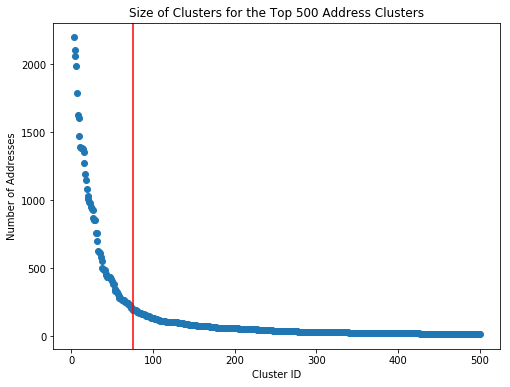

The top 75 clusters (in terms of size) contain 29.62% of the addresses.


In [117]:
clusters = pd.read_csv('clusters.csv')
gb = clusters.groupby('cluster_id', as_index = False).count()
# plt.bar(gb['addrs'][:1000])
plt.figure(figsize=(8,6))
plt.scatter(gb['cluster_id'][2:500], gb['addr'][2:500])
plt.axvline(75, color = 'red')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Addresses')
plt.title('Size of Clusters for the Top 500 Address Clusters')
plt.show()
percent = round(sum(gb['addr'][:75])/sum(gb['addr']) * 100, 2)
print(f'The top 75 clusters (in terms of size) contain {percent}% of the addresses.')

In [5]:
def add_label(addr, label, entity):
#   this utility allows us to label all addrs in a cluster 
#   by providing a single address
    cluster_id = clusters[clusters['addr'] == addr]['cluster_id'].values[0]
    clusters.loc[clusters['cluster_id'] == cluster_id, 
                 ['label', 'entity']] = label, entity

    return clusters
    
add_label('LPRqS1Y7nET9p9ETBD1ndBSkxWSuARMRUZ', 'GAMBLING', 'FortuneJack')
add_label('LhZBnhHjGVssKR87f9ZXv1D4pUAEU4q4B4', 'EXCHANGE', 'Binance 3')
add_label('LcNw4i7txvZSWpMBSKSYJMgzvKTBFjQFd9', 'EXCHANGE', 'Indodax')
# LQH5UapBSPDHwSBRwbKgo6gFm79QxiaELR 4
add_label('LXMk3TGeuPKHjHUU37fgPBYgtu5ekLZzcz', 'EXCHANGE', 'YoBit')
add_label('LRTW7dZmtasUUV53PTAhYS8YnPm2ugwh4b', 'EXCHANGE', 'Cryptonator') # wallet
add_label('M8Cpu5hzPBzP7T4f7KgeDBSAfY2q6vaXNy', 'MINING', None)
add_label('LScdfiwDfmnnGUZae83UsyZbvHNyAwxepT', 'EXCHANGE', 'Huobi')
add_label('LVNWBJ2UCFwfdu9GKCywo3sSqiWkJpUETu', 'EXCHANGE', 'Uphold')
add_label('MDiSqrndFTsQKvwkVkzUKF73hsX6fWR4eG', 'EXCHANGE', 'CoinPayments') #payment gateway
add_label('MB391cADC4XXjhbUDwYaBg3f4CRBrGTaD4', 'EXCHANGE', 'Payeer')
add_label('LaNjprMCaUbSZY5KnBF8d5AJ6WJrdhfPjP', 'EXCHANGE', 'Bittrex')
add_label('Ld1X2bCRE4pSb7myn4xjdakFAadaRNXF6R', 'EXCHANGE', 'Binance 2')
add_label('LNjgEjtvbVpBPyqxeKv77XmwLatH5atTkP', 'EXCHANGE', 'ZB')
# MSK4Kwu1uEeW7aqQsXChy74g6GPAgmya9d 15
add_label('LbMXR4dHkFXupgWAZY377d7vVvpVVjALoP', 'EXCHANGE', 'Poloniex')
# LXtj4TFtXtq1vf22ARupUpnDs71rtCtzGU 17
# LY5bvVH1LFm6xrkWLPR9EcYQb67pKeQSTU 18
add_label('LfCjrYQX5mjZanBDQH5K24JE5KokNc3dfJ', 'EXCHANGE', 'Binance 1')
add_label('MGAgCuuom2bweZwDhGaZfxoBB9KdZTdXZS', 'EXCHANGE', 'Mercado Bitcoin')
# LNGbcvcRsTghhEKoneZtu43mVFQK6tWGaG 21
# MUezwVvsgaeBkcLRDMhzGMBXveL6ufJi3p 22
# LTBApJojYrBmAYcudLd6wmTrKVHwHvraty 23
# LccNHNxewPEgg4bV3h62PjxoESi5DnE1hU 24
# M7y84VgYWuW2fjYSmxJAztnTYqgBxYf4yU 25
# LZPLw8GTzQ6dBdWjv4NTAaJq8sGueRDtdV 26
# MULbzhoqjp1MKR1ip9aorWbnAWR2BaKspE 27
# MEYUes6EvBruLx43Q2GJ6QDYwzReSUYhR9 28
# LdsoyHfbpuTac3fYJgWabqH19XSCtVQzkX 29
# MJmb8hvqz4BwHwVZ8x2K7u2yFSkq8r3NAH 30
add_label('MLQETKSg6vMLgQyB9Z1ZJs4iXETFLAVKef', 'EXCHANGE', 'Bitstamp')
# MTuUvn32kA9j5EWS5GySfGhW2akvPwqGTT 32
# LTXf5oP4pnkN9XbCCqP3nUUAqtYepeyhMc 33
add_label('LUhyPyU4fm3y9EHh1fA7qbxdF74FtoVvRN', 'EXCHANGE', 'EXMO')
add_label('LcuWai9rB86FNdUNNCKgvnuxXysSGUpZRi', 'EXCHANGE', 'CoinExchange')
add_label('MA68NqAVaQaBuroqmFKcqZ75grKPyXWHH2', 'EXCHANGE', 'Bitso')
# MUHVNxR7kdeASkvM5rugPVbrCgegpQhM31 37
# LdyuhX4NpxqCgNAx1YFLJ3cpU8emHUJnhi 38
# LX9MLdo3824uwiN9cExfPZ79kgEp3QDoru 39
add_label('LU5nzkDb1Jwjwd1sMXp6a1Y4MH8GEGKXTk', 'EXCHANGE', 'KuCoin')
add_label('LKYsLLZarBuqDJ3LzHGjjKgEjcEjxthXCG', 'EXCHANGE', 'ZB')
# LZZmVMpMaCzDY82Fj3MFkeyDM5Fi1uvjAu 42
# LLPi2a6Uv2HjQfGhu7Bc44ftHASok1JpKF 43
# LbAsg6m9UTAShzHgwJdPpa2HWLoUwBn8V2 44
add_label('LcYNhVMY8c31bt7Zz8AFsPm8Eo6CyAz4RP', 'EXCHANGE', 'Bitfinex')
# LXfeBhzrtvU8zbuCfLuPbyoQWiXGAbA68c 46
# MHMdce59hNS2o8s6KJsZ6TxViKonHRa6X5 47
add_label('LN1aHvEGrcDuXqMfDq6NKjyKwviBCCZrpa', 'EXCHANGE', 'Gate.io')
# MTezYjBpjDYuVPnbPd75JRcGiyrG4PEhmv 49
# LMUEDudHhAQrXq654QKKjWfqkh1iwJP2Va 50
# LfMK3M4XmWrTi1wUwn75Hcsx3GqhgYUhNx 51
add_label('LeiWMjMtr1Lzs2m6feUyQ7ZB96L26yLnAh', 'EXCHANGE', 'BX.in.th')
# LeLM9oMdpvzfyYPMjJ1odgGENGMshj7GCH 53
# ME9yyTPAJij9vs6apWXZfgnH8Qq7ofmmUu 54
# LhMEP7yTbKGgMMxHyLR7Q8N1WFohuLry49 55
# Lg1SKpdLvcfniomWi11yVmpTv6ShtUgRXL 56
add_label('M9G79smVeLmZwRtAK1mEL38f7uswZnk4AR', 'GAMBLING', 'YOLOdice')
add_label('LcKH7JVVtWSvc9iz1CaNGhU5yqac8YY4JB', 'GAMBLING', 'MbitCasino / BitcoinCasinoUS / BitStarz')
add_label('MRoqikAv8pvLCNL1tXc6roAAQ8sWQcnEWE', 'GAMBLING', 'DuckDice')
# MSq5vW7N92P5co1uFsFc3gThm1gnH1C6tx 60
# LhTwueGFCHsE1r3WNxjajb19MESMEX6PK5 61
# LQ9d7i55hMcvGaY9VpDBZus7qPAyQqt9dj 62
# MSNdDABnbNtjU8CdBu5LSUoUPtifvTHwee 63
add_label('MGbcJKWj4bV1Pzdcq6miPpaLrnCNhKh8uM', 'EXCHANGE', 'WebMoney') # payment settlement
add_label('MTVj9MhWjKnhkwTLscFps2ynf4wZTKprjs', 'EXCHANGE', 'BitBay')
# LNEY4eJEK5hDDaj5se3kv14BzTovH5DZ5D 66
# MMUxuMEM5kMJeozR17tZbct7PfrGNQME2n 67
# LVu8e5vDPKuTyvK4Ni1DbBMCjgd82qv4Er 68
# M8NMVs7Y3o9E3sZ6fE43F67BkeVZ4JM4db 69
# LXqknqbt97BvTUU2a2An4sn9m4Gy3uywbP 70
# LiLDhw1pr1v28KELs7Q5bFmAkBUFmwfhwG 71
# MFQ5wBXJ24mqpLJhucqVbZuBZpupqAu7Dc 72
# LUEZJfxZamtYVgvXNBrcctmAXh9yexmgKX 73
# MGaDkGCfzv4xyu83ob4U4CaQdSJdhtUr8f 74
# LeuTvsCA5xApGGRQas1J9dfx6nz9mprJBC 75
# LbrhRtzRp2EF4ojNPfTCZakDCzRDSHvgM3 76
# Lbk4MGRrtY39jdyADnaG3vBpbQciEHb8KR 77
# LfRmr68irVR6Q6W2payM92PvnBH9482jW6 78
# MTR7nqGfzbreiGGXxibvY7oGFPWXfWLRZm 79
add_label('LTCPodtg91HsKf5xB1MQ5L13CkcSfd2rCV', 'MINING', 'LitecoinPool.org')
# Lfa7A4ktYMJ99D61uvVHnKA6VWvDBsorcC 81
# LhNTqca9hin1Rpepk8mo1WJ9gH1DaNMxzS 82
# LT3nQwxzBvtruSjB3C1R5UTfGomJd6A2RL 83
add_label('LdQC7mCoawyN9MDmDjkUKYpDxivAbtFsuk', 'EXCHANGE', 'HitBTC')
# M8CDFfJ5ZZbWT1SVnXDHxKHwPumdzYPZ44 85
add_label('LP5DmJPfLbNs3uzZWaKyQFkTNrCR7j4Chu', 'EXCHANGE', 'Kraken')
# LcM9HBAZ4BYUYnGXtWwhJE4Y6AFDge6Ska 87
# MMdhYCT3ocnVyLSHBQNSj9RWwtMUsgAeW8 88
# MLhYSAXCwBXPup8a62xFWQZmWjNuYcro4y 89
add_label('MLSj88LppdnTXPWBN1MbY399UCCXCKvY4w', 'EXCHANGE', 'Alpha Change')
# MNK39SsBiq9PWjiY1ETpNGS7va5M5vWyat 91
# MJBsNuBYnCfsrNE9pVoKeU3DspQwrvs3xw 92
add_label('M9SfmJeymTxVBrauUJsNEpHogY8jqPGRwR', 'EXCHANGE', 'CryptoBridge')
add_label('M9YaCyNpqTbNZ3tRwwTKCoat58ux9kzZ8m', 'GAMBLING', '1xBit')
add_label('MLTkbKnob3V6DtZFQ3bbJZtzteWUcdRz9Z', 'EXCHANGE', 'TradeSatoshi')
# MHrsQzDa5gDZwDZescQS2scb88F4nBgFxV 96
add_label('MHd3ridcTrtBbdXBtPssCuqzDT99mJKmZf', 'EXCHANGE', 'Livecoin')
add_label('MBg2bhbEN5HXPcq5VghThX3iJB2djfVmnk', 'EXCHANGE', 'QuadrigaCX')
add_label('Lec94JCcKNUvpxAjhgv1YXVdgB5ZDkmP3N', 'GAMBLING', 'LuckyGames')
# LP1NaZDCBZY6CXpRJxG4FiJMffsrhoSHLY 100

# ---------------------------------------------------------------------
add_label('LdUEVLExGMpHcya77zxt5dfyoKCtXxWhGm', 'MINING', 'F2Pool')
add_label('LZo1qx6S5JEVh43KahTFBdvnkVFeQCz9Ze', 'MINING', 'Poolin.com')
add_label('LLgJTbzZMsRTCUF1NtvvL9SR1a4pVieW89', 'MINING', 'AntPool')
add_label('LhkFjuGkVcdriLU2HWnph1tSLd9Fk7deCn', 'MINING', 'Prohashing')
add_label('LUazv9uUA4rmdmm54HjzTH72vRahHaKJSc', 'MINING', 'Mining Dutch')
add_label('LaQASpgm6oWTJ4sYDF5xJHdiZYkMP7uSW1', 'MINING', 'MiningPoolHub')
add_label('LLMRAtr3qBje2ySEa3CnZ55LA4TQMWnRY3', 'MINING', 'LTC.top')
add_label('LfmssDyX6iZvbVqHv6t9P6JWXia2JG7mdb', 'MINING', 'ViaBTC')
add_label('LLpN93cN6oNhL6PA615tiwr2CXauiPGGr1', 'MINING', None)
add_label('LaKd2Pa578Zg51xLb4UiXabeZe3q24XbR6', 'MINING', None)
add_label('LR5FzTHXfa4aGtozDJN5QmifNbVFxAwdui', 'MINING', None)
add_label('LZ43jcFdxNVpJWJ6o3neYEsnqEGxQTsP9M', 'MINING', None)

# ---------------------------------------------------------------------
add_label('LQqCmx6oEuHHTLF82wWAaVpfmHNZfi2SvW', 'GAMBLING', '999Dice')
add_label('LKeCCvMavn8bawyeyEhLkwjBM6SJZHGh69', 'GAMBLING', '999Dice')

add_label('MMfrXgS3j1mwD87BPZtkGEhnHRDXZN2pHh', 'EXCHANGE', 'Coinone')
add_label('LddFLSodo495K4C8AbDbt3kLQ2E19DDyzt', 'EXCHANGE', 'Coinbase')
# clusters.to_csv('clusters.csv', index=False)


percent = (1 - sum(clusters['label'].isna()) / len(clusters)) * 100
num_clusters_labeled = sum(clusters.groupby('cluster_id').count()['label'] > 0)
print(f'Labeled {round(percent, 2)}% of the data ({num_clusters_labeled} clusters).')
clusters = clusters.fillna('OTHER')

In [6]:
def cluster_by_id(cluster_id):
    return clusters[clusters['cluster_id'] == cluster_id]
    
# cluster_by_id(100)

In [7]:
def cluster_by_addr(addr):
    cluster_id = clusters[clusters['addr'] == addr]['cluster_id'].values[0]
    return cluster_by_id(cluster_id)

# cluster_by_addr('LP1NaZDCBZY6CXpRJxG4FiJMffsrhoSHLY')

## Visualizing the Graph

In [43]:
with open('clusters.pickle', 'rb') as file:
    clusters_sets = pickle.load(file)

clusters_sets.sort(key=len, reverse=True)
clusters_sets = clusters_sets[500:506]

def pairs(lst):
    i = iter(lst)
    first = prev = item = next(i)
    for item in i:
        yield prev, item
        prev = item
    yield item, first
        
graph = networkx.Graph()
for cluster in clusters_sets:
    for edge in pairs(cluster):
        graph.add_edge(*edge)

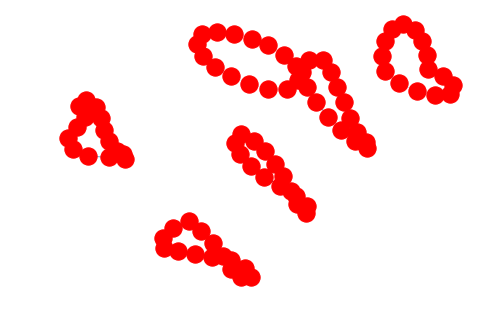

In [74]:
# colors = range(sum([len(cluster) for cluster in clusters_sets]))
networkx.draw_(graph, edge_color = colors, edge_cmap=plt.cm.Blues)

## Feature Construction

In [10]:
def feature_const_in(x):
    d = {}
    d['total_fee_in'] = x['fee'].sum()
    d['avg_feerate_in'] = (x['fee']/x['tx_size']).mean()
    d['total_tx_inputs_val'] = x['inputs_value'].sum()
    d['total_tx_input_count'] = x['input_count'].sum()
    d['total_input_tx'] = x['inputs_addresses'].count()
    d['total_is_coinbase_in'] = x['is_coinbase'].sum().astype(int)
    return pd.Series(d, index=['total_fee_in', 
                               'avg_feerate_in', 
                               'total_tx_inputs_val', 
                               'total_tx_input_count', 
                               'total_input_tx', 
                               'total_is_coinbase_in'])

# inputs_table = df.groupby('inputs_addresses').apply(feature_const_in)
# inputs_table = inputs_table.reset_index()

# inputs_table

In [11]:
def feature_const_out(x):
    d = {}
    d['total_fee_out'] = x['fee'].sum()
    d['avg_feerate_out'] = (x['fee']/x['tx_size']).mean()
    d['total_tx_outputs_val'] = x['outputs_value'].sum()
    d['total_tx_output_count'] = x['output_count'].sum()
    d['total_output_tx'] = x['outputs_addresses'].count()
    d['total_is_coinbase_out'] = x['is_coinbase'].sum().astype(int)
    return pd.Series(d, index=['total_fee_out', 
                               'avg_feerate_out', 
                               'total_tx_outputs_val', 
                               'total_tx_output_count', 
                               'total_output_tx', 
                               'total_is_coinbase_out'])

# outputs_table = df.groupby('outputs_addresses').apply(feature_const_out)
# outputs_table = outputs_table.reset_index()
# outputs_table

In [12]:
# result = pd.merge(left = inputs_table, right = outputs_table,left_on = 'inputs_addresses',right_on = 'outputs_addresses',how = 'left')
# result = result.fillna(0)
# result.to_csv('result.csv', index=False)
result = pd.read_csv('result.csv')

In [13]:
res_mod = pd.merge(left = clusters, right = result, left_on = "addr", right_on = "inputs_addresses", how = "left")
res_mod = res_mod.fillna(0)
res_mod.head(5)

,addr,cluster_id,label,entity,inputs_addresses,total_fee_in,avg_feerate_in,total_tx_inputs_val,total_tx_input_count,total_input_tx,total_is_coinbase_in,outputs_addresses,total_fee_out,avg_feerate_out,total_tx_outputs_val,total_tx_output_count,total_output_tx,total_is_coinbase_out
0,LPRqS1Y7nET9p9ETBD1ndBSkxWSuARMRUZ,1,GAMBLING,FortuneJack,LPRqS1Y7nET9p9ETBD1ndBSkxWSuARMRUZ,15644400.0,100.347654,1993722.0,1056.0,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,LXJ5VWG1aj29eMFX5gcmrRvaF7ZPPYAFqA,1,GAMBLING,FortuneJack,LXJ5VWG1aj29eMFX5gcmrRvaF7ZPPYAFqA,15022800.0,100.362091,2000414.0,1014.0,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,LUfj6N3Qcs8ArpZNCceLQ8dGcwYwkfUonH,1,GAMBLING,FortuneJack,LUfj6N3Qcs8ArpZNCceLQ8dGcwYwkfUonH,15082000.0,100.328619,2000138.0,1018.0,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,LZbS3KXvkEh6wUaaz6mFhzsmKmgtjVy4gF,1,GAMBLING,FortuneJack,LZbS3KXvkEh6wUaaz6mFhzsmKmgtjVy4gF,16177200.0,100.367291,1897460.0,1092.0,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,LSyMcvADDU9n7yrP9n8ej759MWK9E2QmZC,1,GAMBLING,FortuneJack,LSyMcvADDU9n7yrP9n8ej759MWK9E2QmZC,11352400.0,100.342950,60000000.0,766.0,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Classification

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

target = 'label'
col_to_drop = [
    target,
    "addr",
    "cluster_id",
    "entity",
    "inputs_addresses",
    "outputs_addresses"
]
y = res_mod[target]
X = scale(res_mod.drop(col_to_drop,axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


import time
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [15]:

names = [
    "Nearest Neighbors",   
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes", 
    "QDA"
]

classifiers = [
    KNeighborsClassifier(4), 
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

for name, clf in zip(names, classifiers):
    start = time.time()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = round(clf.score(X_test, y_test), 2)


#calculate accuracy
    from sklearn.metrics import classification_report
    print(name)
    print('-' * 15)
    print(classification_report(y_test, pred))
    print(f'Score: {score}')
    end = time.time()
    elapsed = round(end - start, 2)
    print(f'Elapsed time: {elapsed}s')
    print('_' * 75)

Nearest Neighbors
---------------
              precision    recall  f1-score   support

    EXCHANGE       0.73      0.79      0.76      6030
    GAMBLING       0.94      0.88      0.91      1995
      MINING       0.81      0.79      0.80       407
       OTHER       0.96      0.95      0.96     37262

    accuracy                           0.93     45694
   macro avg       0.86      0.85      0.86     45694
weighted avg       0.93      0.93      0.93     45694

Score: 0.93
Elapsed time: 12.65s
___________________________________________________________________________
Decision Tree
---------------
              precision    recall  f1-score   support

    EXCHANGE       0.80      0.81      0.81      6030
    GAMBLING       0.92      0.90      0.91      1995
      MINING       0.90      0.90      0.90       407
       OTHER       0.97      0.97      0.97     37262

    accuracy                           0.94     45694
   macro avg       0.90      0.89      0.90     45694
weighted avg

## Model Selection by Cross Validation

In [16]:
from sklearn.model_selection import cross_val_score, KFold

names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest"
]

classifiers = [
    KNeighborsClassifier(4),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

clfs = dict(zip(names, classifiers))
scores = []

for idx, clf in enumerate(classifiers):
    scores.append(
        cross_val_score(clf, X, y, 
                        cv=KFold(shuffle=True)))

scores = [np.mean(score) for score in scores]
max_score = max(scores)
max_idx = scores.index(max_score)
best_clf = names[max_idx]
print(f'Best classifier: {best_clf} with score of {round(max_score, 2)}')

Best classifier: Random Forest with score of 0.95


## Metrics

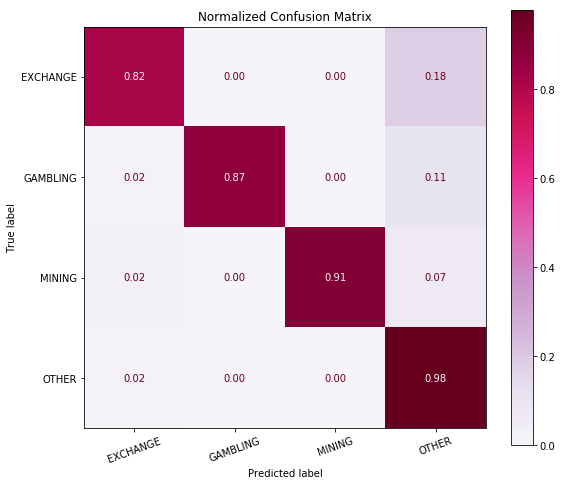

In [75]:
from sklearn.metrics import plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = classifiers[max_idx].fit(X_train, y_train)


mat = plot_confusion_matrix(clf, X_test, y_test,
#                             display_labels = ["EXCHANGE", "GAMBLING", "MINING", "OTHER"],
                            cmap = plt.cm.PuRd,
                            values_format = '.2f',
                            xticks_rotation = 20,
                            normalize = 'true'
                        )
plt.title('Normalized Confusion Matrix')
mat.figure_.set_size_inches(9,8)
# plt.savefig('confusion.png')
# mat.confusion_matrix

In [92]:
# proportion of dataset that belongs to each label
(res_mod.groupby('label').count() / sum(res_mod.groupby('label').count()['addr'])).reset_index()[['label','addr']]

,label,addr
0,EXCHANGE,0.131642
1,GAMBLING,0.044216
2,MINING,0.009073
3,OTHER,0.815068


In [93]:
len(set(df['tx_hash']))

154664